# Feature Engineering for Fraud Detection

## Objective
This notebook creates behavioral, temporal, and geolocation features
to enhance fraud detection performance.
## Feature Engineering Strategy

- Time-based features capture suspicious transaction timing.
- Velocity features detect automated or scripted behavior.
- Country features capture geo-risk patterns.
- No target leakage features are introduced.


🌍 IP → Country Merge


In [1]:

# Fraud Detection Feature Engineering Pipeline
# Allow imports from src/
import sys
from pathlib import Path
import pandas as pd
import numpy as np

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data_loader import load_fraud_data, load_ip_country_data
from src.preprocessing import clean_fraud_data


# Load raw data
df = load_fraud_data("../data/raw/Fraud_Data.csv")
ip_df = load_ip_country_data("../data/raw/IpAddress_to_Country.csv")

# Clean fraud data
df = clean_fraud_data(df)

df.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [2]:
from src.geo_utils import convert_ip_to_int, merge_ip_country




fraud_df = convert_ip_to_int(df)
fraud_df = merge_ip_country(fraud_df, ip_df)
print(fraud_df.head())

fraud_df[["ip_address", "ip_int", "country"]].head()

     user_id         signup_time       purchase_time  purchase_value  \
634   247547 2015-06-28 03:00:34 2015-08-09 03:57:29              47   
635   220737 2015-01-28 14:21:11 2015-02-11 20:28:28              15   
636   390400 2015-03-19 20:49:09 2015-04-11 23:41:23              44   
637    69592 2015-02-24 06:11:57 2015-05-23 16:40:14              55   
638   174987 2015-07-07 12:58:11 2015-11-03 04:04:30              51   

         device_id  source browser sex  age    ip_address  class    ip_int  \
634  KIXYSVCHIPQBR     SEO  Safari   F   30  1.677886e+07      0  16778864   
635  PKYOWQKWGJNJI     SEO  Chrome   F   34  1.684205e+07      0  16842045   
636  LVCSXLISZHVUO     Ads      IE   M   29  1.684366e+07      0  16843656   
637  UHAUHNXXUADJE  Direct  Chrome   F   30  1.693873e+07      0  16938732   
638  XPGPMOHIDRMGE     SEO  Chrome   F   37  1.697198e+07      0  16971984   

     lower_bound_ip_address  upper_bound_ip_address    country  
634              16778240.0      

,ip_address,ip_int,country
634,1.677886e+07,16778864,Australia
635,1.684205e+07,16842045,Thailand
636,1.684366e+07,16843656,China
637,1.693873e+07,16938732,China
638,1.697198e+07,16971984,Thailand


Mapping IP addresses to countries enables the detection
of geographically anomalous transactions.


⚙️ Time & Velocity Features

D:\Python\Week-5-6\fraud-detection\src\feature_engineering.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .rolling(window)
D:\Python\Week-5-6\fraud-detection\src\feature_engineering.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .rolling(window)


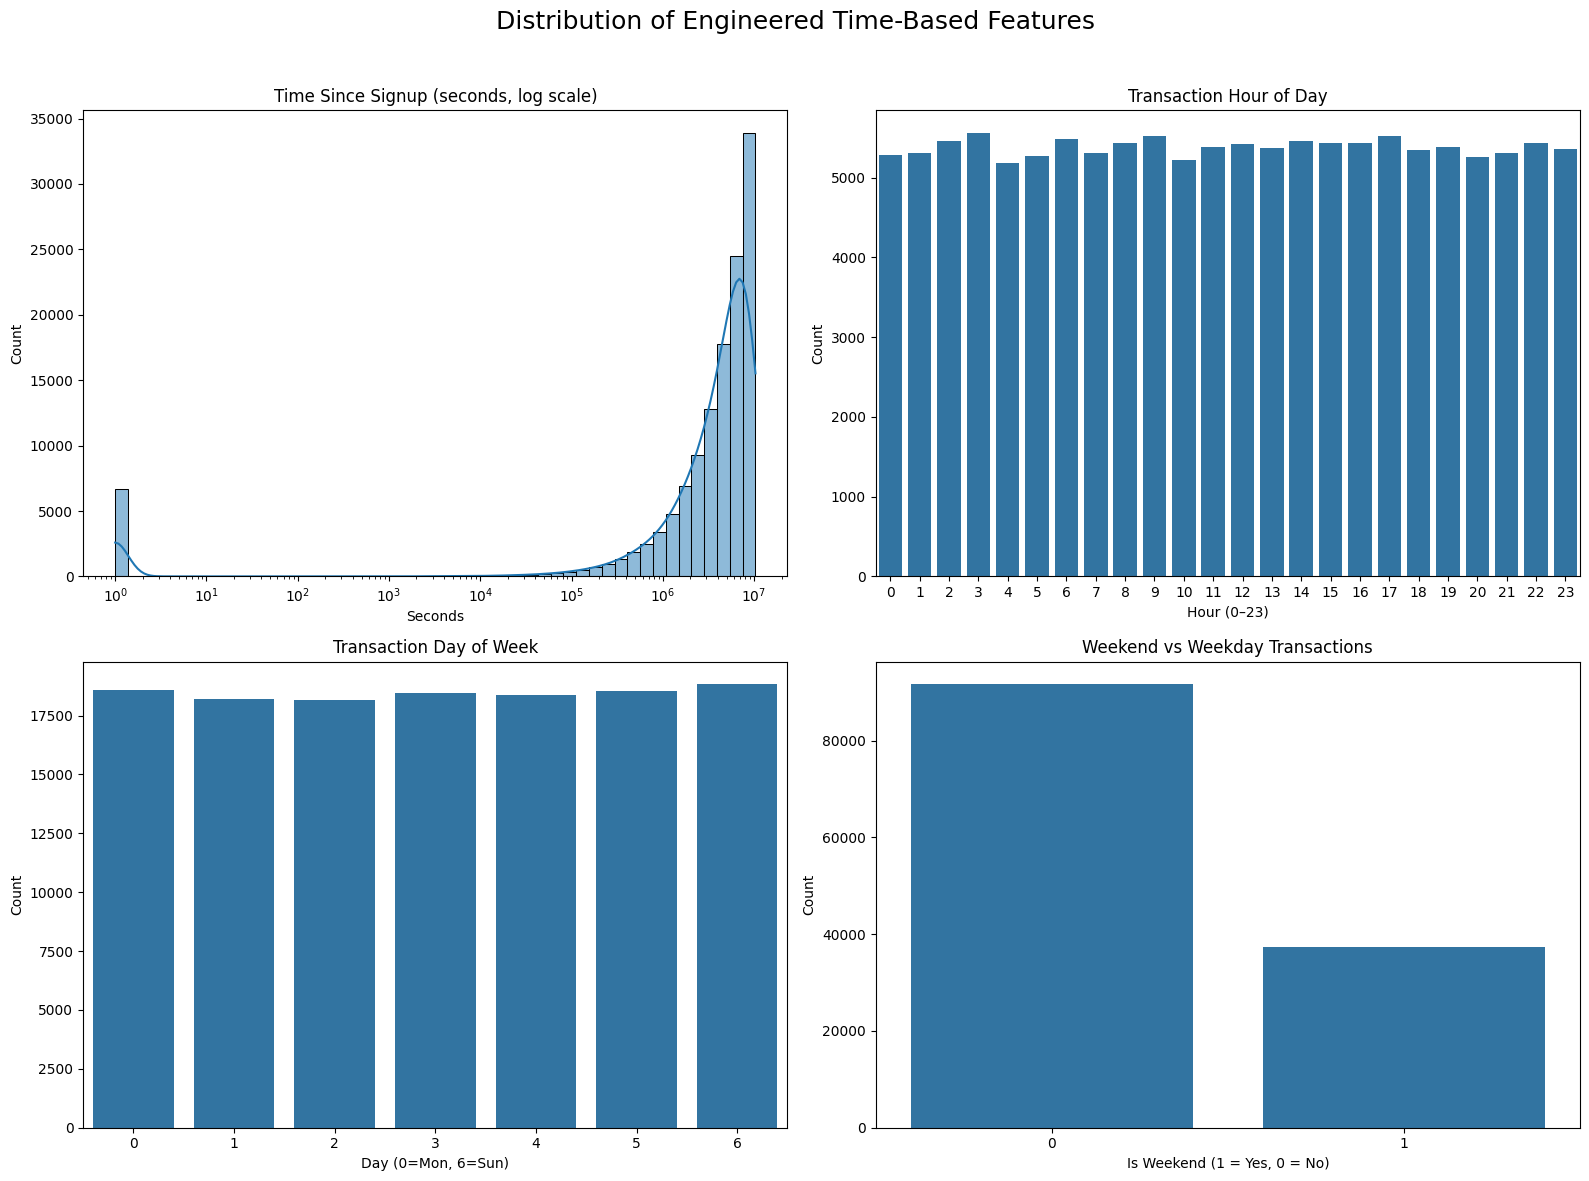

In [16]:
#🕒 Time-Based Features
from src.feature_engineering import add_time_features, add_transaction_velocity

fraud_df = add_time_features(fraud_df)
fraud_df = add_transaction_velocity(fraud_df)
fraud_df[["hour_of_day", "day_of_week", "time_since_signup"]].head()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Distribution of Engineered Time-Based Features", fontsize=18)

# 1️⃣ Time Since Signup (log-scaled)
sns.histplot(
    fraud_df["time_since_signup"],
    bins=50,
    log_scale=True,
    ax=axes[0, 0],
    kde=True
)
axes[0, 0].set_title("Time Since Signup (seconds, log scale)")
axes[0, 0].set_xlabel("Seconds")
axes[0, 0].set_ylabel("Count")

# 2️⃣ Hour of Day
sns.countplot(
    x="hour_of_day",
    data=fraud_df,
    ax=axes[0, 1]
)
axes[0, 1].set_title("Transaction Hour of Day")
axes[0, 1].set_xlabel("Hour (0–23)")
axes[0, 1].set_ylabel("Count")

# 3️⃣ Day of Week
sns.countplot(
    x="day_of_week",
    data=fraud_df,
    ax=axes[1, 0]
)
axes[1, 0].set_title("Transaction Day of Week")
axes[1, 0].set_xlabel("Day (0=Mon, 6=Sun)")
axes[1, 0].set_ylabel("Count")

# 4️⃣ Weekend Indicator
sns.countplot(
    x="is_weekend",
    data=fraud_df,
    ax=axes[1, 1]
)
axes[1, 1].set_title("Weekend vs Weekday Transactions")
axes[1, 1].set_xlabel("Is Weekend (1 = Yes, 0 = No)")
axes[1, 1].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Time-based features capture behavioral patterns,
such as fraud occurring late at night or soon after signup.

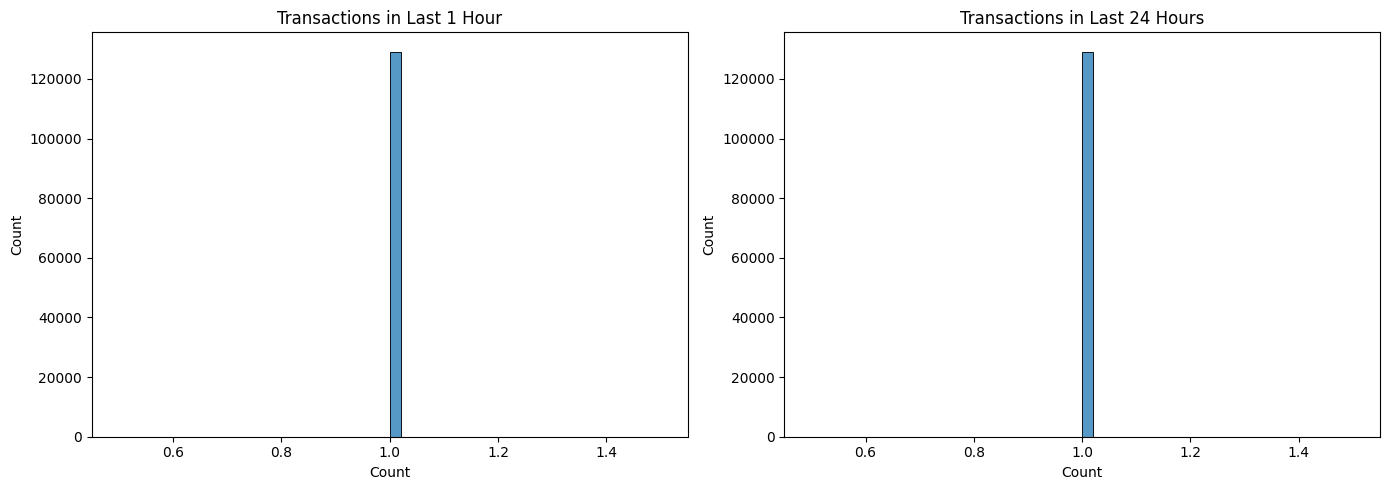

,purchase_time,user_id,signup_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,ip_int,lower_bound_ip_address,upper_bound_ip_address,country,hour_of_day,day_of_week,is_weekend,time_since_signup,transactions_last_1H,transactions_last_24H
0,2015-02-21 10:03:37,2,2015-01-11 03:47:13,54,FGBQNDNBETFJJ,SEO,Chrome,F,25,8.802175e+08,...,880217484,8.724152e+08,8.891924e+08,United States,10,5,1,3564984.0,1.0,1.0
1,2015-09-26 21:32:16,4,2015-06-02 16:40:57,41,MKFUIVOHLJBYN,Direct,Safari,F,38,2.785906e+09,...,2785906106,2.785542e+09,2.786066e+09,Switzerland,21,5,1,10039879.0,1.0,1.0
2,2015-08-13 11:53:07,8,2015-05-28 07:53:06,47,SCQGQALXBUQZJ,SEO,Chrome,M,25,3.560567e+08,...,356056736,3.523215e+08,3.690988e+08,United States,11,3,0,6667201.0,1.0,1.0
3,2015-03-04 20:56:37,12,2015-01-10 06:25:12,35,MSNWCFEHKTIOY,Ads,Safari,M,19,2.985180e+09,...,2985180352,2.985034e+09,2.985296e+09,Mexico,20,2,0,4631485.0,1.0,1.0
4,2015-03-12 12:46:23,16,2015-02-03 13:48:23,9,FROZWSSWOHZBE,Direct,IE,M,32,5.783125e+08,...,578312545,5.704253e+08,5.872026e+08,United States,12,3,0,3193080.0,1.0,1.0


In [42]:
# Add transaction velocity features only if they don't already exist to avoid merge suffix conflicts
if not {"transactions_last_1H", "transactions_last_24H"}.issubset(fraud_df.columns):
	fraud_df = add_transaction_velocity(fraud_df)
else:
	# remove any accidental suffixed duplicates from prior merges
	dup_cols = [c for c in fraud_df.columns if ("transactions_last" in c) and (c.endswith(("_x", "_y")))]
	if dup_cols:
		fraud_df = fraud_df.drop(columns=dup_cols)

fraud_df.filter(like="transactions_last").head()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Transactions in last 1 hour
sns.histplot(
    fraud_df["transactions_last_1H"],
    bins=50,
    ax=axes[0]
)
axes[0].set_title("Transactions in Last 1 Hour")
axes[0].set_xlabel("Count")

# Transactions in last 24 hours
sns.histplot(
    fraud_df["transactions_last_24H"],
    bins=50,
    ax=axes[1]
)
axes[1].set_title("Transactions in Last 24 Hours")
axes[1].set_xlabel("Count")

plt.tight_layout()
plt.show()

fraud_df.head()




Fraud often occurs in bursts.
Velocity features quantify rapid transaction activity,
which is uncommon for legitimate users.

Numerical features will be scaled using StandardScaler
to support distance-based and gradient-based models.
Scaling is not applied to PCA features in the credit card dataset.

Both datasets exhibit severe class imbalance.
Resampling techniques such as SMOTE will be applied
only to training data during modeling to avoid information leakage.


💾 Save Processed Data

In [43]:

#💾 Save Processed Data
fraud_df.to_csv("../data/processed/fraud_data_features.csv", index=False)

## Model-Ready Preprocessing Pipeline


Feature / Target Separation

In [44]:

# Datetime conversion
df["signup_time"] = pd.to_datetime(df["signup_time"])
df["purchase_time"] = pd.to_datetime(df["purchase_time"])

# Time since signup (hours)
df["time_since_signup"] = (
    (df["purchase_time"] - df["signup_time"])
    .dt.total_seconds() / 3600
)

# OPTIONAL: velocity feature (skip if not ready)
# df["transactions_last_24h"] = ...

#assert "time_since_signup" in df.columns
# assert "transactions_last_24h" in df.columns


In [45]:
print("DataFrame used for modeling:")
print(df.columns)

X = df.drop(columns=["class"])
y = df["class"]

print(X.columns)
print(y.name)


DataFrame used for modeling:
Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'time_since_signup'],
      dtype='object')
Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address',
       'time_since_signup'],
      dtype='object')
class


In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


Feature Type Identification

In [47]:
num_features = [
    "purchase_value",
    "time_since_signup",
    "age"
]

cat_features = [
    "browser",
    "source",
    "sex"
]


In [48]:
required_features = num_features + cat_features
missing = [c for c in required_features if c not in X_train.columns]
assert not missing, f"Missing features: {missing}"


Scaling & Encoding Pipeline

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline


numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)
print(df.columns)# Ensure datetime types
df["signup_time"] = pd.to_datetime(df["signup_time"])
df["purchase_time"] = pd.to_datetime(df["purchase_time"])

# Time since signup (in hours)
df["time_since_signup"] = (
    (df["purchase_time"] - df["signup_time"])
    .dt.total_seconds() / 3600
)

df["time_since_signup"].describe()



Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'time_since_signup'],
      dtype='object')


count    151112.000000
mean       1370.008125
std         868.406422
min           0.000278
25%         607.431528
50%        1368.429306
75%        2123.479028
max        2879.992222
Name: time_since_signup, dtype: float64

In [50]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(X_train_processed.shape)
print(X_test_processed.shape)



(120889, 13)
(30223, 13)


Train/Test Split (BEFORE SMOTE)

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


Apply Scaling & Encoding

In [52]:
print("Numeric features expected by pipeline:", num_features)
print("Columns actually in X_train:", list(X_train.columns))
print("Columns actually in X_test:", list(X_test.columns))

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(X_train.columns)
print(X_test.columns)

print(X_train_processed.shape)
print(X_test_processed.shape)


Numeric features expected by pipeline: ['purchase_value', 'time_since_signup', 'age']
Columns actually in X_train: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'time_since_signup']
Columns actually in X_test: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'time_since_signup']
Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address',
       'time_since_signup'],
      dtype='object')
Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address',
       'time_since_signup'],
      dtype='object')
(120889, 13)
(30223, 13)


Class Imbalance Handling (SMOTE)

In [53]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_processed,
    y_train
)


print("Before SMOTE:")
print(y_train.value_counts(normalize=True))

print("\nAfter SMOTE:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))
print(X_train_resampled.shape)
print(y_train_resampled.shape)
# Save Processed and Resampled Data
np.save("../data/processed/X_train.npy", X_train_resampled)
np.save("../data/processed/y_train.npy", y_train_resampled)
np.save("../data/processed/X_test.npy", X_test_processed)
np.save("../data/processed/y_test.npy", y_test)
# EDA of Fraud Data


Before SMOTE:
class
0    0.906352
1    0.093648
Name: proportion, dtype: float64

After SMOTE:
class
0    0.5
1    0.5
Name: proportion, dtype: float64
(219136, 13)
(219136,)
